In [1]:
from itertools import product
from collections import deque
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
from ca_utils import get_lookup_indicies, get_binary_rule_rep, get_kmers, process_inpt

# 1- Binary state 1-D Cellular Automata

This notebook will cover:
- Basics of CAs as indexing functions
- Implementation of 1D CAs
- Generation of CA update map based ona randomly chosen rule & input sequence

## a) Defining the closed set of CA rules, identifying a singular rule and processing an arbitrary length input through a rule

Cellular automata rules come in sets. To define this set, two elements are required:
1. A set of discreet states
2. A rule order

A set of CA rules is defined as all the CA rule sequences that are of a specific length and consistent of all the possible permutations of these discreet states of that length.

The length of the CA rule sequence is defined as the number of permutatons of sequeneces of the discreet states that are rule order in length.

for example, lets define the following:
    - states:  S = [0, 1]
    - rule order O = 3
    
Thus the set permutations of these states that are 3 in length are ['000', '001', '010', '011', '100', '101', '110', '111'].

Note: There is an implicit order here, and That is by choice of how we ordered the permutations. The order does not necissairaly matter so long as it is explicitly stated and carried through. In this case, the order used will be the one expressed above.

The count of these permutations is 8. This can be simple expressed as:
    
    L(R) = L(S) ^ O where,
        R : any CA Rule within the CA rule set
        L(R) : sequence length of any rule in the CA rule set
        S : set of states
        L(S) : length of the set of states
        O : rule order
        
To total size (i.e. magnitude) of the CA rule set can then be calculated by counting all the possible permutations of the states that are of L(R) long. i.e.
    
    |R| = L(S) ^ L(R)
    or 
    |R| = L(S) ^ (L(S) ^ O)
    
In the case above, substituting for L(S) = 2, O = 3, we get |R| = 256.

So in short, for S = [0, 1] & O = 2, we have defined a set of 256 CA rules (that are all the 8-long permutation sequences of the states in S). examples are: '01001101', '01001101', '11110000', ...

Similarly, we have defined as way to access the specific states of any given rule defined in this set but using the ordered set of indicies (permutations of states in S of length )) -> ['000', '001', '010', '011', '100', '101', '110', '111'].

We can also order the set of CA rules by numbering them. The most trivial way of doing this is by converting the CA rule sequence from the binary representation into an integer. For example: 

    '00000000' = 0
    '00100001' = 33
    '10001001' = 137
    '11110110' = 246
    
So in conclusion, Any CA Rule has this form, where S1...S8 are all one of [0, 1], and specific rules 33, 137 & 212 are:

| Indicies 	| Rule Set 	| Rule 33 	| Rule 137 	| rule 212 	|
|:--------:	|:--------:	|:-------:	|:--------:	|:--------:	|
|    000   	|    S1    	|    0    	|     1    	|     1    	|
|    001   	|    S2    	|    0    	|     0    	|     1    	|
|    010   	|    S3    	|    1    	|     0    	|     0    	|
|    011   	|    S4    	|    0    	|     0    	|     1    	|
|    100   	|    S5    	|    0    	|     1    	|     0    	|
|    101   	|    S6    	|    0    	|     0    	|     1    	|
|    110   	|    S7    	|    0    	|     0    	|     0    	|
|    111   	|    S8    	|    1    	|     1    	|     0    	|


As such, Cellular Automata rules, can be viewed as indexing functions, where the input is a specific permutation of its possible indicies, and the output is the corresponding state

This would be the same as saying:
    
    Rule(index) = state.
    
Note that the only valid indicies are the ones that are of length of O and consist of only states '0' or '1'

so the process here is simple:
    
    - take an input, say '101', and a rule say # 212.
    - convert the input to teh appropriate index, in this case 6
    - covert the rul into the bibary rep, in this case '11010100'
    - return the 6th state of the binary rule rep, in this case 1
    
And this is the basis of a CA rule indexing.

The same process can be extended to any arbitrary length input so long as it is longer that O. This is done by breaking the input in consecutive [k-mers](https://en.wikipedia.org/wiki/K-mer), and repeating the indexing process. this can be done as follows:

    - for rule @ 212 the indexed binary rep is:
    
|   index kmer 	| 000 	| 001 	| 010 	| 011 	| 100 	| 101 	| 110 	| 111 	|
|:------------:	|:---:	|:---:	|:---:	|:---:	|-----	|-----	|-----	|-----	|
| index number 	|  0  	|  1  	|  2  	|  3  	| 4   	| 5   	| 6   	| 7   	|
| Rule 212     	| 1   	| 1   	| 0   	| 1   	| 0   	| 1   	| 0   	| 0   	|
    
    - for input '101100101', the corresponding kmers (looping & non-looping) and rule outputs would be would be:
    
|non-looping  k-mer	| 101 	| 011 	| 110 	| 100 	| 001 	| 010 	| 101 	|
|:---------------:	|:---:	|:---:	|:---:	|:---:	|-----	|-----	|-----	|
| Rule 212 output 	|  1  	|  1  	|  0  	|  0  	| 1   	| 1   	| 1   	|

| looping k-mers  	| 110 	| 101 	| 011 	| 110 	| 100 	| 001 	| 010 	| 101 	| 011 	|
|:---------------:	|-----	|:---:	|:---:	|:---:	|:---:	|-----	|-----	|-----	|-----	|
| Rule 212 output 	| 0   	|  1  	|  1  	|  0  	|  0  	| 1   	| 1   	| 1   	| 1   	|    
    
    - thus, the output for the rule 212 with input '101100101' would be:
        non-looping kmers: '1100111'
        looping kmers:     '011001111'

To implement this, a few functions are needed:
1. get_lookup_indicies: defines a global mapping of the ordered kmers and the corresponding index in a specific rule sequence
2. get_binary_rule_rep: converts a rule number into its binary representation
3. get kmers: converts an input sequence into a set of kmers
4. process input: process an input sequence through a given rule using the 3 functions above.

These funcions are implemented in the ca_utils.py file found in the same directory of this workbook.

## b) Function Testing

The following will implement the above mentioned functions

### b.1) get_lookup_indicies(inpt_states, order=3)

notes - observe that:
1. the permutations are a function of:
    - the size of the input states (fixed = 2 oin this case)
    - and the rule order
2. the indicies corresponding to the indices changes based on the summplied order of the input states (i.e. '01', vs '10')
    

In [3]:
inpt_states = ['01', '10'] # binary states for this use case
rule_orders = [1, 2, 3]

for test_inpt_states, test_order in product(inpt_states, rule_orders):
    kmer_indicies_mapping = get_lookup_indicies(inpt_states=test_inpt_states, order=test_order)
    print(f'\nFor states {test_inpt_states} & a rule order = {test_order} , the fixed CA rule lookup indicies are:')
    pprint(kmer_indicies_mapping)


For states 01 & a rule order = 1 , the fixed CA rule lookup indicies are:
{'0': 0, '1': 1}

For states 01 & a rule order = 2 , the fixed CA rule lookup indicies are:
{'00': 0, '01': 1, '10': 2, '11': 3}

For states 01 & a rule order = 3 , the fixed CA rule lookup indicies are:
{'000': 0, '001': 1, '010': 2, '011': 3, '100': 4, '101': 5, '110': 6, '111': 7}

For states 10 & a rule order = 1 , the fixed CA rule lookup indicies are:
{'0': 1, '1': 0}

For states 10 & a rule order = 2 , the fixed CA rule lookup indicies are:
{'00': 3, '01': 2, '10': 1, '11': 0}

For states 10 & a rule order = 3 , the fixed CA rule lookup indicies are:
{'000': 7, '001': 6, '010': 5, '011': 4, '100': 3, '101': 2, '110': 1, '111': 0}


### b.2) get_binary_rule_rep(rule_number, rule_order)

notes:

Rule numbers are limited by the number of kmers (& thus indicies) that can act as inputs.

So for O = 3 (rule order) & states = '01', we know that there are a possible of 256 rules each with a representaion length of 8. We will make this parametric to show the effects

In [4]:
states = '01'
states_count = len(states)
rule_orders = [2,3,4]

for test_rule_order in rule_orders:
    
    rule_length = states_count** test_rule_order
    rule_space_maginitude = states_count ** rule_length
    print(f'For states {states} & O = {test_rule_order}:')
    print(f'\tThe rule space Magnitude is {rule_space_maginitude} & the rule representation length is {rule_length}')
    
    for _ in range(3):
        rule_number = np.random.randint(0, rule_space_maginitude)
        rule_rep = get_binary_rule_rep(rule_number=rule_number, rule_order=test_rule_order)
        print(f'\tSample Rule #: {rule_number} has rule rep: {rule_rep}')
    print('\n')

For states 01 & O = 2:
	The rule space Magnitude is 16 & the rule representation length is 4
	Sample Rule #: 11 has rule rep: 1011
	Sample Rule #: 15 has rule rep: 1111
	Sample Rule #: 12 has rule rep: 1100


For states 01 & O = 3:
	The rule space Magnitude is 256 & the rule representation length is 8
	Sample Rule #: 158 has rule rep: 10011110
	Sample Rule #: 206 has rule rep: 11001110
	Sample Rule #: 56 has rule rep: 00111000


For states 01 & O = 4:
	The rule space Magnitude is 65536 & the rule representation length is 16
	Sample Rule #: 7939 has rule rep: 0001111100000011
	Sample Rule #: 18873 has rule rep: 0100100110111001
	Sample Rule #: 3056 has rule rep: 0000101111110000




### b.3) get_kmers(inpt_seq, k=3, looping=False)

Note:

For even number orders and the looping case, the extra kmer overlap is deffered to the end of the kmers list

In [5]:
input_sequences = ['101', '101001', '10110100']
k_vals = [2, 3, 4]
looping_vals = [True, False]

for inpt, k, looping in product(input_sequences, k_vals, looping_vals):
    kmers = get_kmers(inpt_seq=inpt, k=k, looping=looping)
    if kmers:
        if looping:
            assert(len(kmers) == len(inpt))
        else:
            assert(len(kmers) == len(inpt) - k + 1)
    print(f'{"looping" if looping else "non-looping"} {k}-mers for input: {inpt}:\n{kmers}\n')

looping 2-mers for input: 101:
['10', '01', '11']

non-looping 2-mers for input: 101:
['10', '01']

looping 3-mers for input: 101:
['110', '101', '011']

non-looping 3-mers for input: 101:
['101']

looping 4-mers for input: 101:
None

non-looping 4-mers for input: 101:
None

looping 2-mers for input: 101001:
['10', '01', '10', '00', '01', '11']

non-looping 2-mers for input: 101001:
['10', '01', '10', '00', '01']

looping 3-mers for input: 101001:
['110', '101', '010', '100', '001', '011']

non-looping 3-mers for input: 101001:
['101', '010', '100', '001']

looping 4-mers for input: 101001:
['1101', '1010', '0100', '1001', '0011', '0110']

non-looping 4-mers for input: 101001:
['1010', '0100', '1001']

looping 2-mers for input: 10110100:
['10', '01', '11', '10', '01', '10', '00', '01']

non-looping 2-mers for input: 10110100:
['10', '01', '11', '10', '01', '10', '00']

looping 3-mers for input: 10110100:
['010', '101', '011', '110', '101', '010', '100', '001']

non-looping 3-mers for i

In [6]:
rule110 = get_binary_rule_rep(rule_number=110, rule_order=3)
print(rule110)
indicies = get_lookup_indicies(inpt_states='10', order=3)
pprint([(kmer, rule110[indicies[kmer]]) for kmer in indicies.keys()])

01101110
[('111', '0'),
 ('110', '1'),
 ('101', '1'),
 ('100', '0'),
 ('011', '1'),
 ('010', '1'),
 ('001', '1'),
 ('000', '0')]


In [7]:
kmers = get_kmers('1011001010', looping=True)
results = [(kmer, rule110[indicies[kmer]]) for kmer in kmers]
pprint(results)

[('010', '1'),
 ('101', '1'),
 ('011', '1'),
 ('110', '1'),
 ('100', '0'),
 ('001', '1'),
 ('010', '1'),
 ('101', '1'),
 ('010', '1'),
 ('101', '1')]


### b.4) process_inpt(inpt_seq, rule_number, input_states='01', order=3, looping=True)

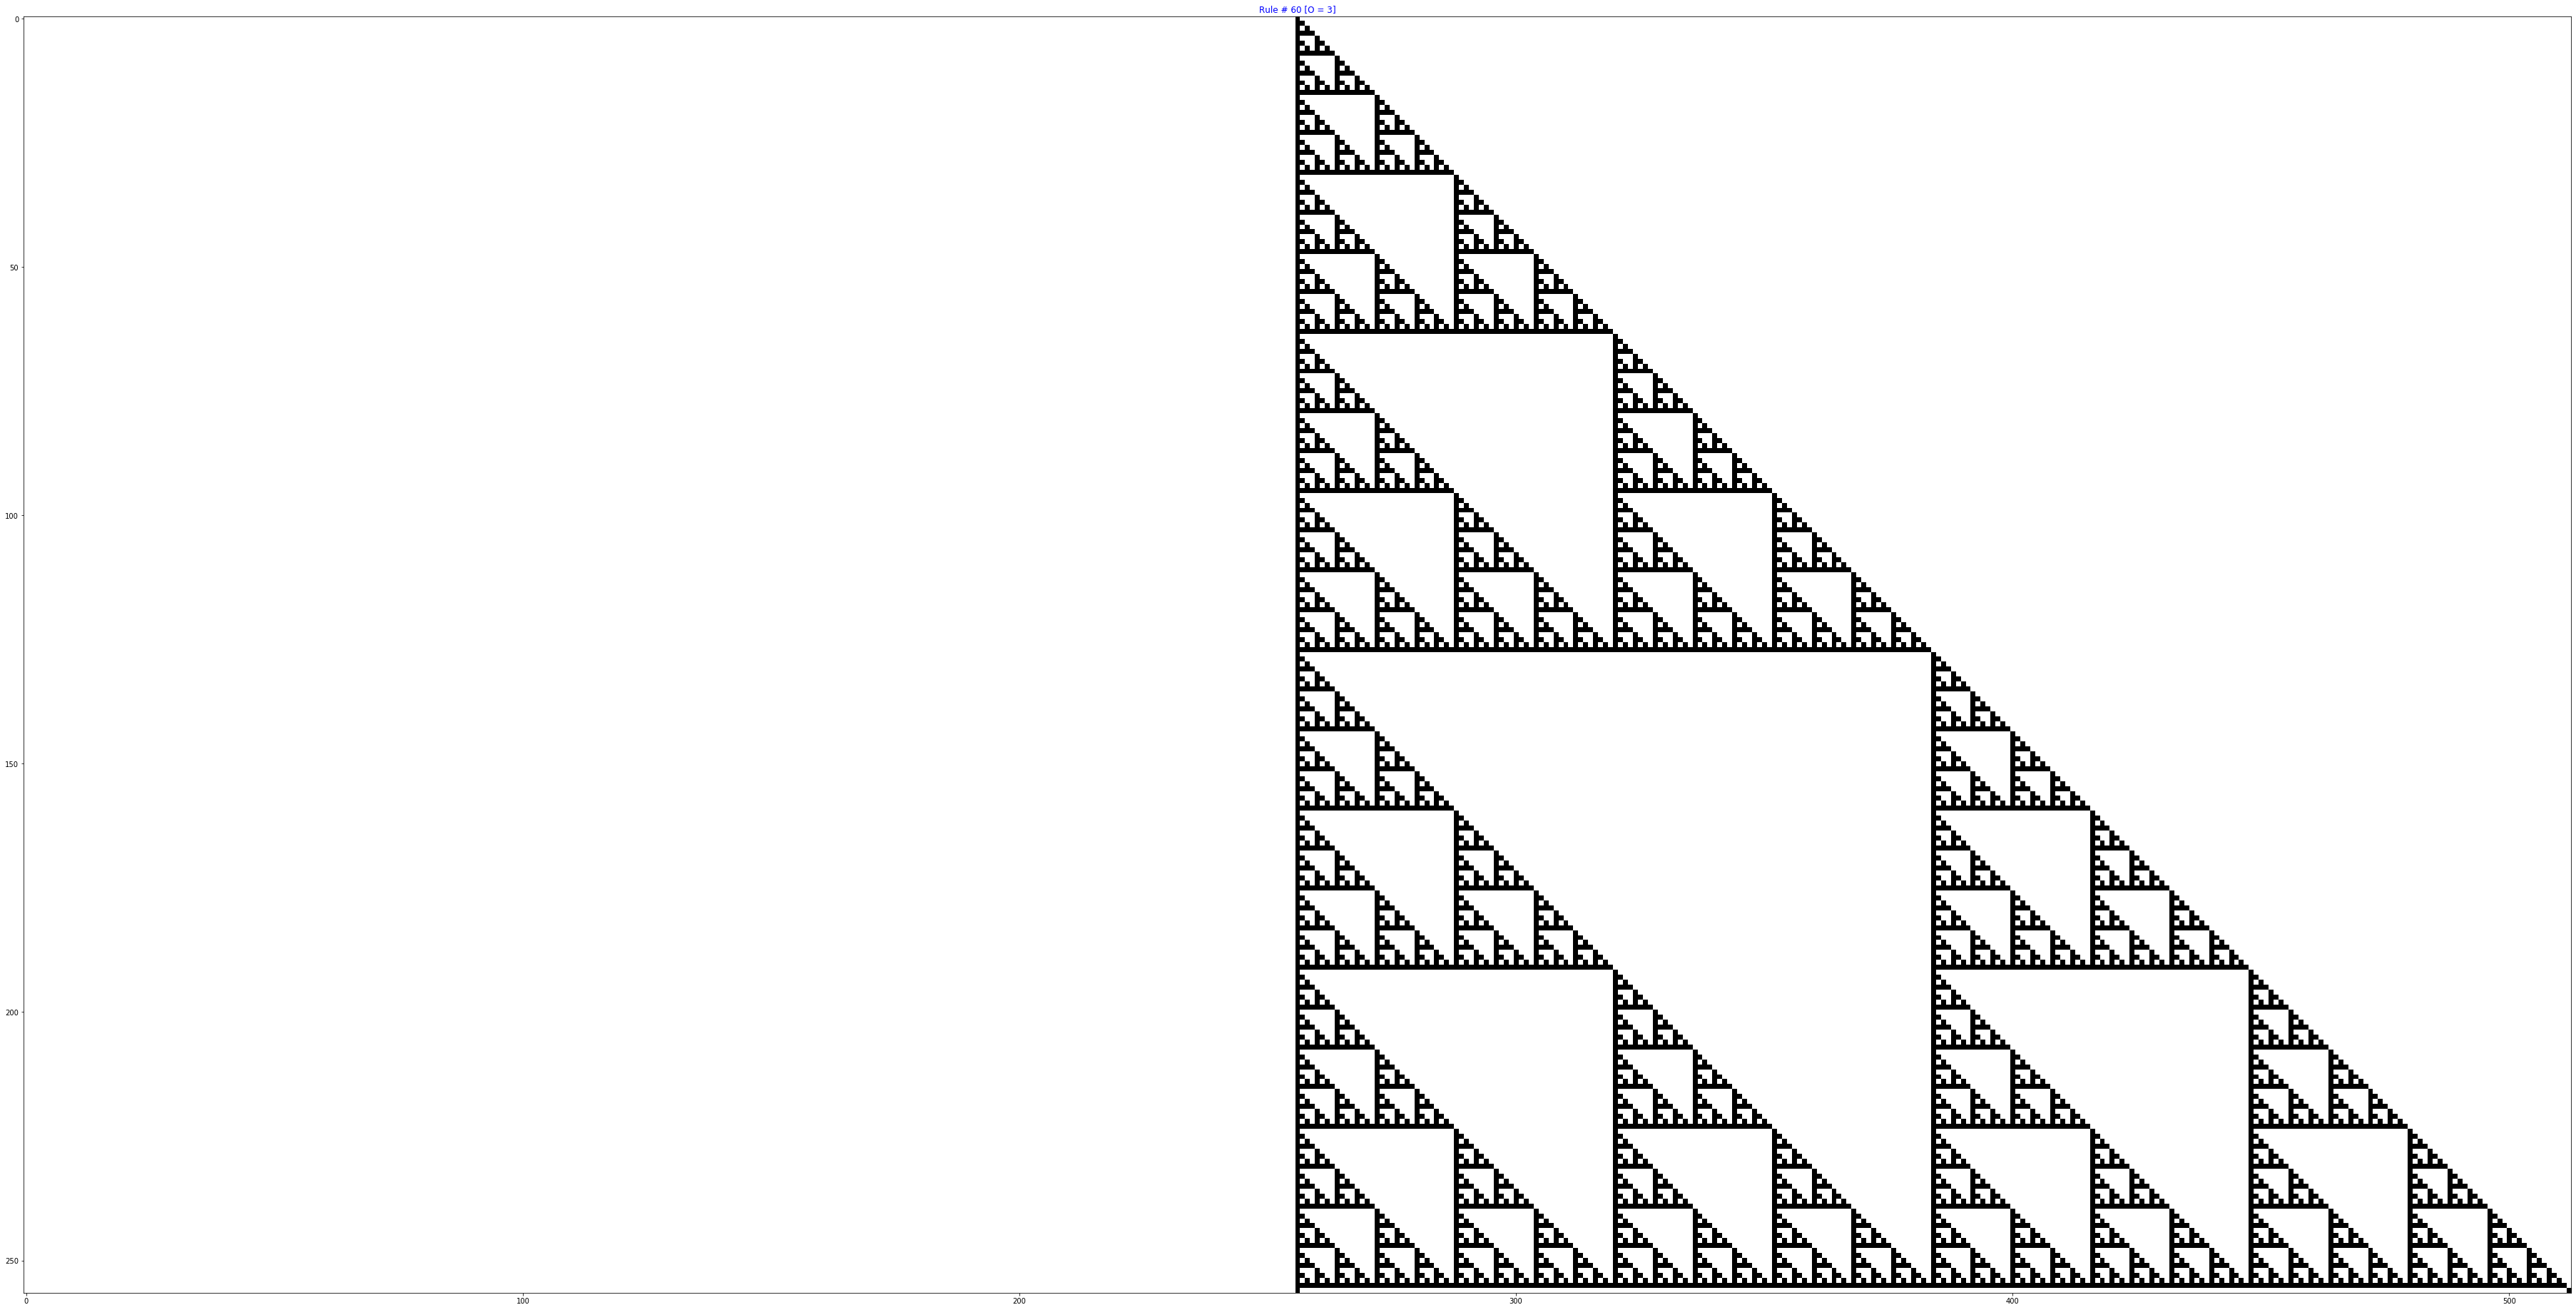

In [139]:
# set input params & choose a random init input
states = '10' # -> to match wolfram's notation 
states_count = len(states)

# set CA rule params & choose a random processing rule
rule_order = 3
rule_space_maginitude = states_count ** states_count ** rule_order
random_rule_number = np.random.randint(0, rule_space_maginitude)

# create a random input of length > O
width_pixels = 512
init_input = ''.join(np.random.choice(list(states), size=512))

# uncomment these to generate wolfram's diagrams
init_input = '0'*int(width_pixels/2)
init_input = init_input + '1' + init_input

# memory of itteration runs
process_history = [init_input]

itteration_counts = int(width_pixels/2)
for itt in range(itteration_counts):
    inpt_seq = process_history[-1]
    next_inpt_seq = process_inpt(inpt_seq=inpt_seq,
                                 rule_number=random_rule_number,
                                 input_states=states,
                                 order=rule_order)
    process_history.append(next_inpt_seq)

# plot output

# Black/White color map for states
color_map = {'0':[65, 102, 245], '1':[255, 174, 66]}
color_map = {'1':[0]*3, '0':[255]*3}

# convert states to Black/White RGBA
process_history = [[color_map[val] for val in seq] for seq in process_history]

fig = plt.figure(figsize=(64,64))
ax = plt.imshow(process_history)
plot_title = f'Rule # {random_rule_number} [O = {rule_order}]' 

title_obj = plt.title(plot_title)
plt.setp(title_obj, color='b')

plt.show()